# Testing the dask-kubernetes cluster
The goal of this notebook is to use the dask-kubernetes created cluster to process some data. We will use the code of [dask tutorial](https://github.com/dask/dask-tutorial) ( specifically the [04_dataframe.ipynb](https://github.com/dask/dask-tutorial/blob/master/04_dataframe.ipynb) and [prep.py](https://github.com/dask/dask-tutorial/blob/master/prep.py)) a bit changed to fit a single notebook.

## 1 Getting the data
First we will get data of the flights out of the three airports in the New York City area.

In [1]:
import urllib.request
import dask.dataframe as dd
import os
import tarfile
from glob import glob
import pandas as pd

In [15]:
def flights():
    start = time.time()
    
    here = os.getcwd()
    data_dir = os.path.abspath(os.path.join(here, 'data'))
    
    flights_url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
    flights_raw = os.path.join(data_dir, 'nycflights.tar.gz')
    flightdir = os.path.join(data_dir, 'nycflights')
    jsondir = os.path.join(data_dir, 'flightjson')
    
    N = 10_000
    
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    
    if not os.path.exists(flights_raw):
        print("- Downloading NYC Flights dataset... ", end='', flush=True)
        url = flights_url
        urllib.request.urlretrieve(url, flights_raw)
        print("done", flush=True)

    if not os.path.exists(flightdir):
        print("- Extracting flight data... ", end='', flush=True)
        tar_path = os.path.join(data_dir, 'nycflights.tar.gz')
        with tarfile.open(tar_path, mode='r:gz') as flights:
            flights.extractall('data/')

        print("done", flush=True)

    if not os.path.exists(jsondir):
        print("- Creating json data... ", end='', flush=True)
        os.mkdir(jsondir)
        for path in glob(os.path.join(data_dir, 'nycflights', '*.csv')):
            prefix = os.path.splitext(os.path.basename(path))[0]
            df = pd.read_csv(path, nrows=N)
            df.to_json(os.path.join(data_dir, 'flightjson', prefix + '.json'),
                       orient='records', lines=True)
        print("done", flush=True)
    else:
        return

    end = time.time()
    print("** Created flights dataset! in {:0.2f}s**".format(end - start))


In [16]:
flights()

## 2 Creating the cluster
Now let's change the worker file to have the same data of the notebook mounted at in /home/arkaisho directory.

In [2]:
import yaml

worker = ""
with open("daskKubernetes/worker.yaml", 'r') as stream:
    try:
        worker = yaml.safe_load(stream)
    except:
        print("File not found")
        
worker['spec']['volumes'] = [{'name':'storage','persistentVolumeClaim':{'claimName':'claim'}}]
worker['spec']['containers'][0]['volumeMounts'] = [{'name':'storage','mountPath':'/home/arkaisho'}]
print(yaml.dump(worker))

kind: Pod
metadata:
  labels:
    foo: bar
spec:
  containers:
  - args:
    - dask-worker
    - --nthreads
    - '2'
    - --no-dashboard
    - --memory-limit
    - 4GB
    - --death-timeout
    - '60'
    env:
    - name: EXTRA_PIP_PACKAGES
      value: git+https://github.com/dask/distributed
    image: daskdev/dask:2.16.0
    imagePullPolicy: IfNotPresent
    name: dask
    resources:
      limits:
        cpu: '2'
        memory: 4G
      requests:
        cpu: '2'
        memory: 4G
    volumeMounts:
    - mountPath: /home/arkaisho
      name: storage
  restartPolicy: Never
  volumes:
  - name: storage
    persistentVolumeClaim:
      claimName: claim



And finally start the cluster

In [3]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster.from_dict(worker)
cluster.scale(2)

distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://10.42.0.9:36319
distributed.scheduler - INFO -   dashboard at:                     :8787


In [4]:
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-1f3bb1f4-9eb9-11ea-8074-027c2a6b0dbd
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.42.0.9:36319 Dashboard: http://10.42.0.9:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register worker <Worker 'tcp://10.42.0.14:41891', name: 1, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.42.0.14:41891
distributed.core - INFO - Starting established connection


# 3 Testing the cluster with some data
Now run the codes below to test using the cluster with some big data.

In [6]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
len(df)

2611892

In [7]:
%time df.DepDelay.max().compute()

CPU times: user 682 ms, sys: 39.9 ms, total: 722 ms
Wall time: 5.68 s


1435.0

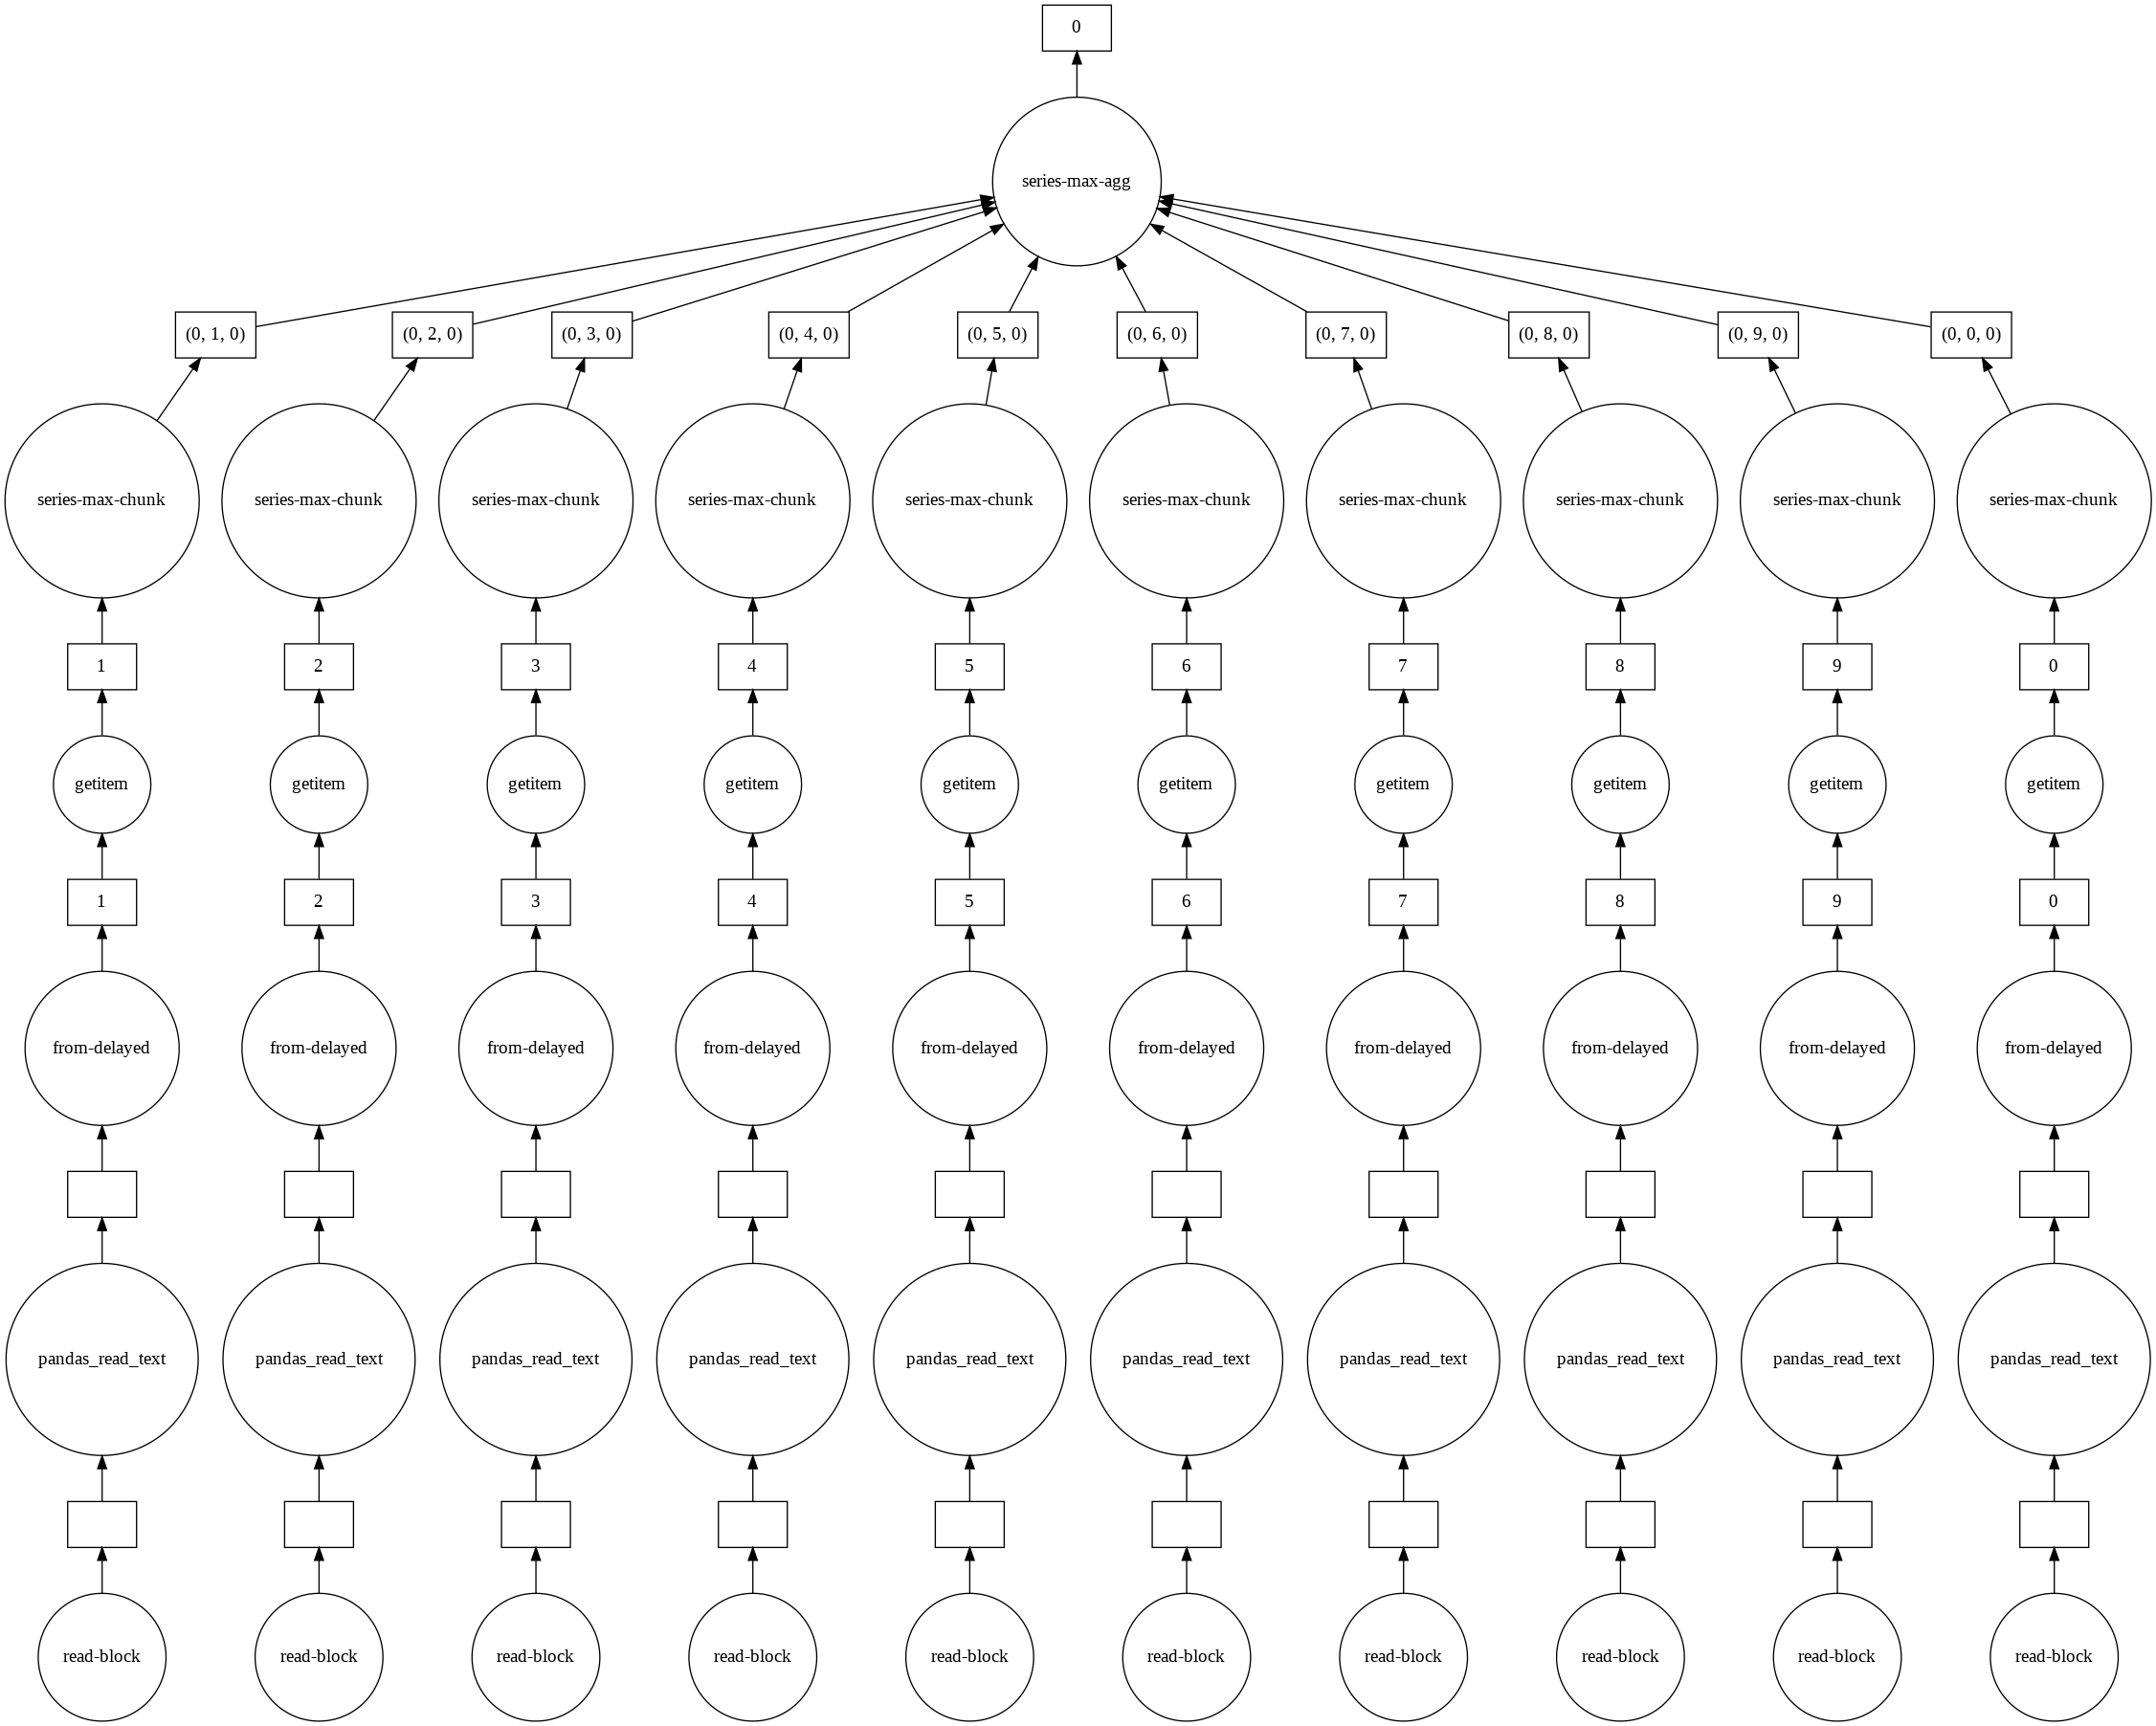

In [13]:
df.DepDelay.max().visualize()

# 4 close the cluster

In [67]:
client.close()
cluster.close()

distributed.scheduler - INFO - Remove client Client-687f39ec-9eb7-11ea-805a-027c2a6b0dbd
distributed.scheduler - INFO - Remove client Client-687f39ec-9eb7-11ea-805a-027c2a6b0dbd
distributed.scheduler - INFO - Close client connection: Client-687f39ec-9eb7-11ea-805a-027c2a6b0dbd
distributed.scheduler - INFO - Scheduler closing...
distributed.scheduler - INFO - Scheduler closing all comms
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.42.0.12:39217', name: 0, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.42.0.12:39217
distributed.scheduler - INFO - Lost all workers
